### OCR

Description

In this project we propose to develop an OCR system to read water meters. 
This project does not have a real customer, but a well-organized GitHub repository containing 
custom OCR system will improve visibility of your profile and increase your chances to get your 
first data-science position. 

Aim of the project is to develop and train a deep-learning system to extract readings from the images.

This notebook includes some exploratory analysis

In [1]:
import pandas as pd
import numpy as np
import cv2
import imutils
import os, sys
import json
import ast
import matplotlib.pyplot as plt
#. import seaborn as sns
from random import sample
from imutils import contours
import pytesseract
from PIL import Image
from skimage.exposure import is_low_contrast
pd.set_option('MAX_ROWS', None)

In [2]:
path = r'TlkWaterMeters/'
df = pd.read_csv(os.path.join(path, 'data.tsv'), sep='\t')

In [3]:
df.shape

(1244, 3)

In [4]:
df.head()

,photo_name,value,location
0,id_53_value_595_825.jpg,595.825,"{'type': 'polygon', 'data': [{'x': 0.30788, 'y..."
1,id_553_value_65_475.jpg,65.475,"{'type': 'polygon', 'data': [{'x': 0.26133, 'y..."
2,id_407_value_21_86.jpg,21.860,"{'type': 'polygon', 'data': [{'x': 0.27545, 'y..."
3,id_252_value_313_322.jpg,313.322,"{'type': 'polygon', 'data': [{'x': 0.21967, 'y..."
4,id_851_value_305_162.jpg,305.162,"{'type': 'polygon', 'data': [{'x': 0.06983, 'y..."


In [5]:
img_files = sample(os.listdir(os.path.join(path, 'images')), 6)

In [6]:
mask_files = sample(os.listdir(os.path.join(path, 'masks')), 5)

In [7]:
collage_files = sample(os.listdir(os.path.join(path, 'collage')), 5)

In [8]:
def plot_images(imgs, titles=[], r=2, c=3, figsize=(10, 10)):
    _, axes = plt.subplots(r, c, figsize=figsize)
    for title, img, ax in zip(titles, imgs, axes.flatten()):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    # plt.axis('off')
    if len(imgs) < r*c:
        axes.flat[-1].set_visible(False)
    plt.show()

### Sample of Image files

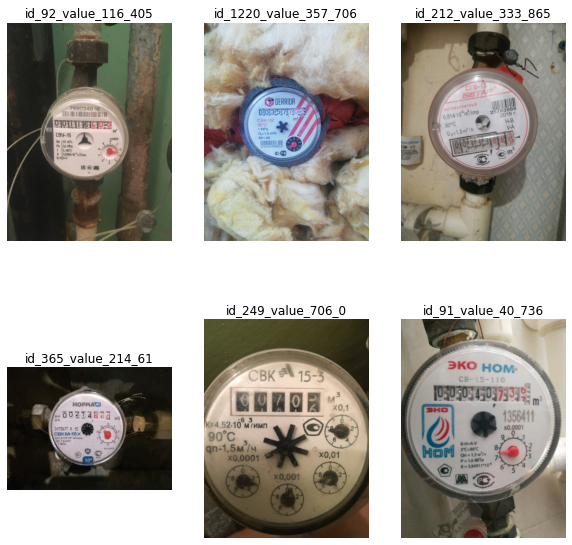

In [9]:
imgs = []
titles = []
for file in img_files:
    img = cv2.imread(os.path.join(path, 'images', file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgs.append(img)
    titles.append(file.split('.')[0])
plot_images(imgs, titles)

### Sample of Mask files

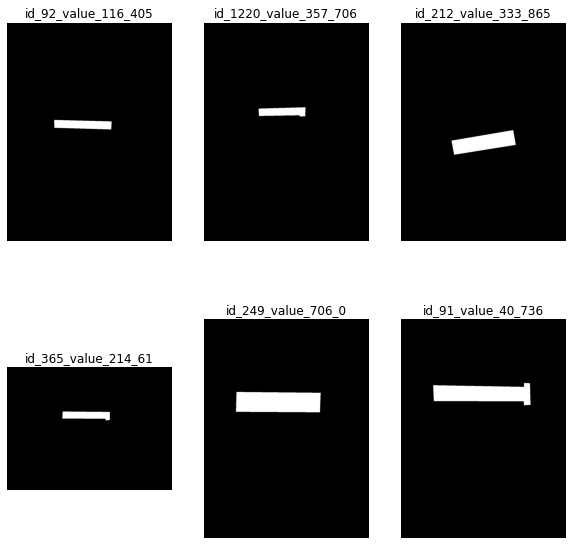

In [10]:
imgs = []
titles = []
for file in img_files:
    img = cv2.imread(os.path.join(path, 'masks', file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgs.append(img)
    titles.append(file.split('.')[0])
plot_images(imgs, titles)

### Sample of Collage files

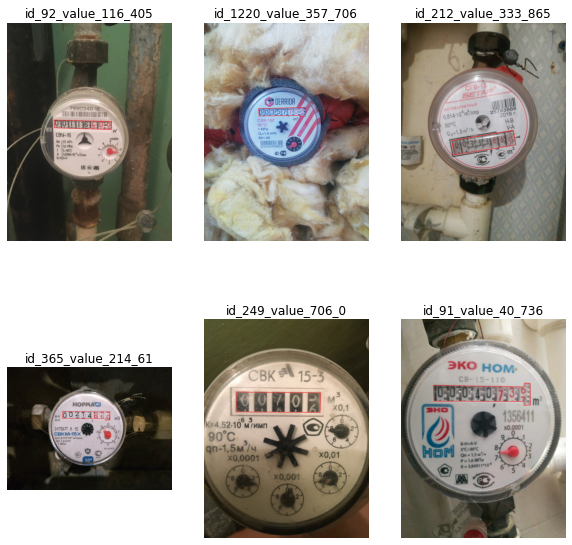

In [11]:
imgs = []
titles = []
for file in img_files:
    img = cv2.imread(os.path.join(path, 'collage', file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgs.append(img)
    titles.append(file.split('.')[0])
plot_images(imgs, titles)

**Observations**

1) The viewing angle is very varied: some appear to be shot from top view, front view or some weird angle

2) The lighting condition also varies significantly

3) There is background clutter, and some of the water meter displays appear dirty or have reflection of the flash bouncing off the 
glass of the meter

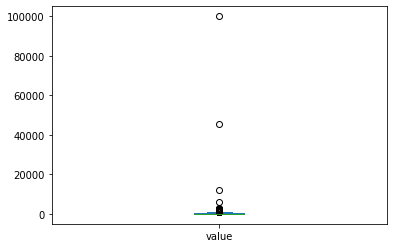

In [12]:
df['value'].plot(kind='box')
plt.show()

**Observation**

Some very extreme meter readings are noted in the distribution of the box plot

In [13]:
df['value'].min(), df['value'].mean(), df['value'].median(), df['value'].max()

(0.0, 422.5065430868168, 188.8075, 99999.539)

In [14]:
sizes = []
for file in os.listdir(os.path.join(path, 'images')):
    img = cv2.imread(os.path.join(path, 'images', file))
    sizes.append(img.shape[:2])

In [15]:
img_dim_df = pd.DataFrame(sizes, columns=['height', 'width'])

<AxesSubplot:>

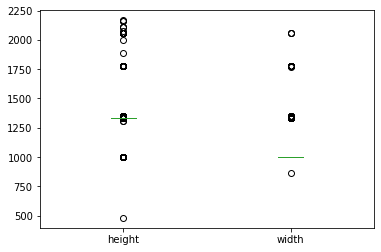

In [16]:
img_dim_df.plot(kind='box')

**Observation**

There is wide variability in the dimensions of the images as well

In [17]:
def create_bounding_box_coordindates(inp, image_folder='images', 
                                     mask_folder='masks',
                                    draw_box=True,
                                    category_index=0,
                                    write_file=False,
                                    out_path='',
                                    file=''):
    """
    Generate normalized bounding box coordinates
    that are consistent with YOLO's v5 model
    https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    """
    # image_path = os.path.join(image_folder, inp)
    mask_path = os.path.join(path, mask_folder, inp)
    # raw_image = cv2.imread(image_path)
    mask_image = cv2.imread(mask_path)
    mask_h, mask_w, _ = mask_image.shape
    where = np.where(mask_image)
    y1, x1, _ = np.amin(where, axis=1)
    y2, x2, _ = np.amax(where, axis=1)

    x_center = (x1 + x2) / 2 / mask_w
    y_center = (y1 + y2) / 2 / mask_h
    w = (x2 - x1) / mask_w
    h = (y2 - y1) / mask_h
#     if not draw_box:
#         # YOLO uses x_center, y_center, width, height format
#         return x_center, y_center, w, h
    if draw_box:   
        # get coordinates to draw bounding box
        x_min = x_center - w / 2
        y_min = y_center - h / 2
        x_max = x_min + w
        y_max = y_min + h

        # return x_center, y_center, w, h
        return x_min, y_min, x_max, y_max
    if write_file:
        with open(os.path.join(out_path, file), 'w') as f:
            f.write(f"{category_index} {x_center} {y_center} {w} {h}\n")

In [18]:
#inp = 'id_1220_value_357_706.jpg'
# inp = 'id_106_value_758_407.jpg'
# inp = 'id_407_value_21_86.jpg'
inp = 'id_1206_value_33_069.jpg'
image_path = os.path.join(path, 'images', inp)
mask_path = os.path.join(path, 'masks', inp)
collage_path = os.path.join(path, 'collage', inp)
raw_image = cv2.imread(image_path)
mask_image = cv2.imread(mask_path)
collage_image = cv2.imread(collage_path)

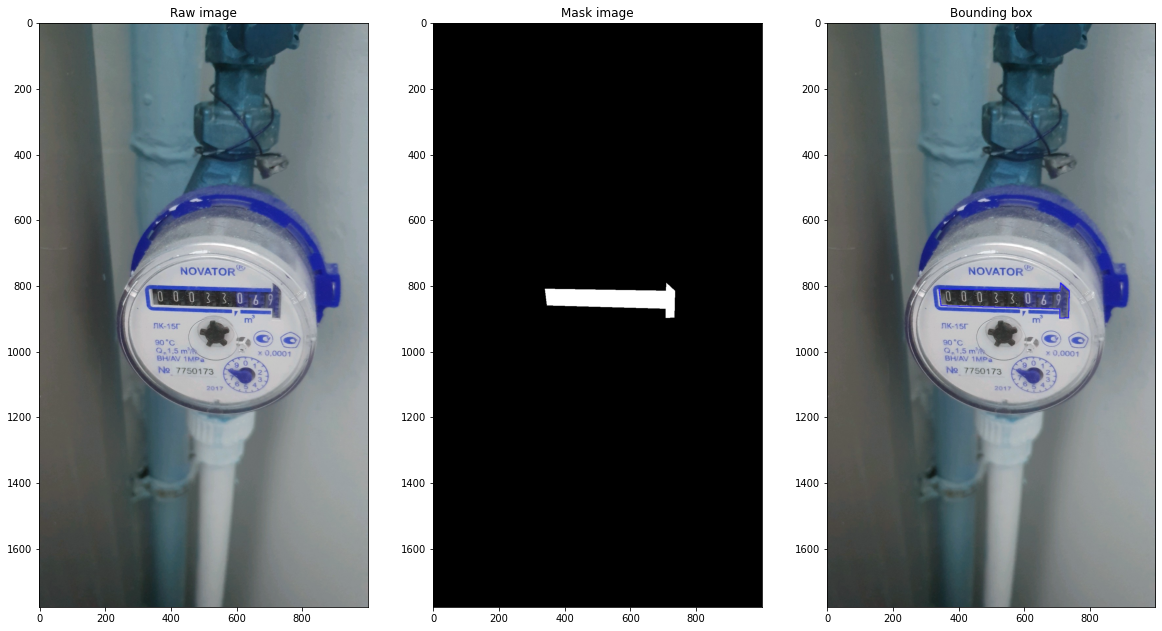

Sizes: Raw - (1778, 1000) Mask - (1778, 1000) Collage - (1778, 1000)


In [19]:
_, axes= plt.subplots(1, 3, figsize=(20, 20))
axes[0].imshow(raw_image)
axes[1].imshow(mask_image)
axes[2].imshow(collage_image)
axes[0].set_title('Raw image')
axes[1].set_title('Mask image')
axes[2].set_title('Bounding box')
plt.show()
print('Sizes: Raw - {} Mask - {} Collage - {}'.format(raw_image.shape[:2], mask_image.shape[:2], collage_image.shape[:2]))

In [20]:
x_min, y_min, x_max, y_max = create_bounding_box_coordindates(inp, image_folder='images', 
                                     mask_folder='masks')

In [21]:
h, w, _ = raw_image.shape
x1, y1 = x_min * w, y_min * h
x2, y2 = x_max * w, y_max * h

cv2.rectangle(
  raw_image,
  (int(x1), int(y1)),
  (int(x2), int(y2)),
  color=(0, 255, 0),
  thickness=2
)
im_arr = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
# convert back to Image object
im = Image.fromarray(im_arr)

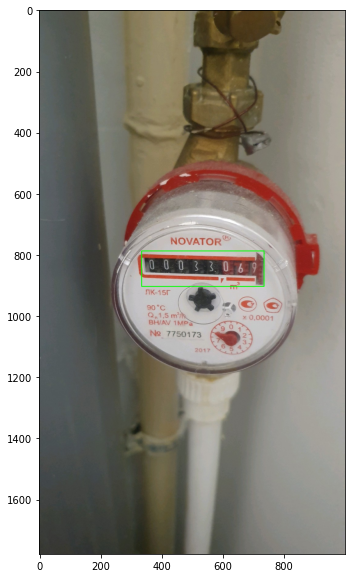

In [22]:
plt.figure(figsize=(10, 10))
plt.clf()
plt.imshow(im)
plt.show()

## Next step

Use pretrained object detection model to detect the water meter reading